Original code in aigenintern/aigenintern1/23-2/MolCLR/230914_MolCLR_Finetune_MTL.ipynb

Check GPU Status: `gpustat -cuFi 1`

In [ ]:
# Setup args for config

from dotmap import DotMap
args = DotMap({
    'device':'cuda:3',
    'learning_config': {
        'init_pred_lr': 2e-3, # initial learning rate for the prediction head
        'init_base_lr': 1e-4, # initial learning rate for the base GNN encoder
        'weight_decay': 1e-6,   # weight decay of Adam
        'pred_layer_depth': 2,  # dimension of pred layer = feat_dim // 2
        'patience': 15, # early stopping patience
    }
})

# BBB CPY3A4 Clearance Solubility
args.data = 'BBB'
args.load_config = DotMap({
    'load': False, # If True, do not train. load from ckpts
    'name': 'BBB Best', # 'CPY3A4 Best'
})

In [ ]:
# Reload modules before run
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import sys
sys.path.append('../')

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

from src.dataset_stl import MolTestDatasetWrapper
from utils_dm import EarlyStopper

In [4]:
datas = DotMap({
    'BBB':{ # this dictionary should match argument of MolTestDatasetWrapper
        'task':'classification', # 'classification' | 'regression'
        'smiles_column':'Drug', # column name of smiles in csv file
        'target':['Y'],
        
        'batch_size':256,
        'num_workers':0, # ??

        'train_path':'../2023-2/TDC/BBB_Martins_train.csv',
        'valid_path':'../2023-2/TDC/BBB_Martins_valid.csv',
        'test_path':'../2023-2/TDC/BBB_Martins_test.csv',

#          For data split
#         'data_path':'../2023-2/TDC/BBB_Martins_train.csv',
#         'valid_size':0.1,
#         'test_size':0.1,
#         'splitting':'random',
    }, 'CPY3A4': { # this dictionary should match argument of MolTestDatasetWrapper
        'task':'classification', # 'classification' | 'regression'
        'smiles_column':'Drug', # column name of smiles in csv file
        'target':['Y'],
        
        'batch_size': 256,
        'num_workers': 0,
        
        'train_path':'../2023-2/TDC/CYP3A4_Veith_train.csv',
        'valid_path':'../2023-2/TDC/CYP3A4_Veith_valid.csv',
        'test_path':'../2023-2/TDC/CYP3A4_Veith_test.csv',
    }, 'Clearance': {# this dictionary should match argument of MolTestDatasetWrapper
        'task':'regression', # 'classification' | 'regression'
        'smiles_column':'Drug', # column name of smiles in csv file
        'target':['Y'],
        
        'batch_size': 256,
        'num_workers': 0,
        
        'train_path':'../2023-2/TDC/Clearance_Hepatocyte_AZ_train.csv',
        'valid_path':'../2023-2/TDC/Clearance_Hepatocyte_AZ_valid.csv',
        'test_path':'../2023-2/TDC/Clearance_Hepatocyte_AZ_test.csv',
    }, 'Solubility': {# this dictionary should match argument of MolTestDatasetWrapper
        'task':'regression', # 'classification' | 'regression'
        'smiles_column':'Drug', # column name of smiles in csv file
        'target':['Y'],
        
        'batch_size': 256,
        'num_workers': 0,
        
        'train_path':'../2023-2/TDC/Solubility_AqSolDB_train.csv',
        'valid_path':'../2023-2/TDC/Solubility_AqSolDB_valid.csv',
        'test_path':'../2023-2/TDC/Solubility_AqSolDB_test.csv',
    }
})


In [5]:
args.data_config = datas[args.data]
args.learning_config.num_tasks = len(args.data_config.target)

model_name= args.load_config.name if args.load_config.load else f'MolCLR_{args.data}-{datetime.now().strftime("%m.%d_%H%M")}'
modelf=f'ckpts/{model_name}.pt'
model_name, modelf

('BBB Best', 'ckpts/BBB Best.pt')

## Set Data
Load data according to args.data_config

In [6]:
# MolTestDatasetWrapper -> src/dataset_test.py
h_dataset = MolTestDatasetWrapper(
    TDC.BBB,
    128,0
)

In [7]:
# trainloader: torch_geometric.loader.DataLoader
trainloader,validloader,testloader=h_dataset.get_data_loaders()

SMILES in dataframe: 1421
SMILES in dataframe: 203
SMILES in dataframe: 406


In [8]:
# len = row / batch_size
len(trainloader), len(validloader), len(testloader)

(6, 1, 2)

# Define MolCLR + MTL Model
Code from https://github.com/yuyangw/MolCLR

Paper: https://www.nature.com/articles/s42256-022-00447-x

GINet_Feat: torch geometric data -> feature embedding

In [9]:
from src.ginet_finetune import *

class GINet_Feat(nn.Module):
    """
    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        drop_ratio (float): dropout rate
        gnn_type: gin, gcn, graphsage, gat
    Output:
        node representations
    """
    def __init__(self, 
        task='classification',
        drop_ratio=0, pool='mean',
    ):
        super(GINet_Feat, self).__init__()
        self.num_layer = 5 # pretrained
        self.emb_dim = 300 # pretrained
        self.feat_dim = 512 # pretrained
        self.drop_ratio = drop_ratio
        self.task = task

        self.x_embedding1 = nn.Embedding(num_atom_type, self.emb_dim) # num_atom_type -> src/ginet_finetune.py
        self.x_embedding2 = nn.Embedding(num_chirality_tag, self.emb_dim)
        nn.init.xavier_uniform_(self.x_embedding1.weight.data)
        nn.init.xavier_uniform_(self.x_embedding2.weight.data)

        # List of MLPs
        self.gnns = nn.ModuleList()
        for layer in range(self.num_layer):
            self.gnns.append(GINEConv(self.emb_dim))

        # List of batchnorms
        self.batch_norms = nn.ModuleList()
        for layer in range(self.num_layer):
            self.batch_norms.append(nn.BatchNorm1d(self.emb_dim))

        if pool == 'mean':
            self.pool = global_mean_pool
        elif pool == 'max':
            self.pool = global_max_pool
        elif pool == 'add':
            self.pool = global_add_pool
        self.feat_lin = nn.Linear(self.emb_dim, self.feat_dim)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        
        h = self.x_embedding1(x[:,0]) + self.x_embedding2(x[:,1])

        for layer in range(self.num_layer):
            h = self.gnns[layer](h, edge_index, edge_attr)
            h = self.batch_norms[layer](h)
            if layer == self.num_layer - 1:
                h = F.dropout(h, self.drop_ratio, training=self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training=self.training)

        h = self.pool(h, data.batch)
        h = self.feat_lin(h)  # just before prediction head 
        
        return h

    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                continue
            if isinstance(param, nn.parameter.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            own_state[name].copy_(param)

def _load_pre_trained_weights(model,device,location=None):
    if location:
        checkpoint_file = location
    else:
        try:
            checkpoints_folder = os.path.join('./ckpt', 'pretrained_gin', 'checkpoints')
            checkpoint_file = os.path.join(checkpoints_folder, 'model.pth')
        except FileNotFoundError:
            print("Pre-trained weights not found. Training from scratch.")
            
    state_dict = torch.load(checkpoint_file, map_location=device)
    model.load_my_state_dict(state_dict)
    print("Loaded pre-trained model with success.")

    return model

Feat_MTL: feature embedding -> [predictions]

In [10]:
class Feat_MTL(nn.Module):
    def __init__(self, 
        task, feat_dim,
         num_layer, num_tasks, pred_act,
    ):
        super(Feat_MTL, self).__init__()
        self.num_layer = num_layer
        self.feat_dim = feat_dim
        self.task = task
        
        if self.task == 'classification':
            self.out_dim = 1
        elif self.task == 'regression':
            self.out_dim = 1
        
        self.pred_heads=nn.ModuleList()
        for _ in range(num_tasks):
            if pred_act == 'relu':
                pred_head = [
                    nn.Linear(self.feat_dim, self.feat_dim//2), 
                    nn.ReLU(inplace=True)
                ]
                for _ in range(self.num_layer - 1):
                    pred_head.extend([
                        nn.Linear(self.feat_dim//2, self.feat_dim//2), 
                        nn.ReLU(inplace=True),
                    ])
            elif pred_act == 'softplus':
                pred_head = [
                    nn.Linear(self.feat_dim, self.feat_dim//2), 
                    nn.Softplus()
                ]
                for _ in range(self.num_layer - 1):
                    pred_head.extend([
                        nn.Linear(self.feat_dim//2, self.feat_dim//2), 
                        nn.Softplus()
                    ])
            else:
                raise ValueError('Undefined activation function')
            
            pred_head.append(nn.Linear(self.feat_dim//2, self.out_dim))
            self.pred_heads.append(nn.Sequential(*pred_head))

    def forward(self, data):
        return torch.cat([head(data) for head in self.pred_heads],dim=1)

    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                continue
            if isinstance(param, nn.parameter.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            own_state[name].copy_(param)

In [171]:
class GINet_Feat_MTL(nn.Module):
    """
    Args:
        drop_ratio (float): dropout rate
    Output:
        node representations
    """
    def __init__(self, 
        task, pred_layer_depth, pred_act, num_tasks,
        drop_ratio=0, pool='mean',
    ):
        super(GINet_Feat_MTL, self).__init__()
        emb_dim=300
        gin_layer_depth = 5
        feat_dim = 512
        
        self.gin = GINet_Feat(task=task,
                             pool=pool,
                             drop_ratio=drop_ratio
                             )
        self.mtl = Feat_MTL(task=task,
                            feat_dim=feat_dim,
                            num_layer=pred_layer_depth,
                            num_tasks=num_tasks,
                            pred_act=pred_act,
                            )

    def forward(self, data):
        feat = self.gin(data)
        out = self.mtl(feat)
        return out

    def load_my_state_dict(self, state_dict):
        self.gin.load_my_state_dict(state_dict)
        self.mtl.load_my_state_dict(state_dict)

## Create Model

In [172]:
model = GINet_Feat_MTL(
            task=args.data_config.task,
            pred_layer_depth = args.learning_config.pred_layer_depth,
            num_tasks = args.learning_config.num_tasks,
            drop_ratio = 0,
            pool = 'mean',
            pred_act = 'relu',
        ).to(args.device)
model = _load_pre_trained_weights(model,args.device, '../aigenintern1/23-2/MolCLR/pretrained_weights/pretrained_gin_model.pth')

Loaded pre-trained model with success.


In [13]:
# set different learning rates for prediction head and base

# 1) check if model_parameters are learnable
layer_list = [] # layer_list = prediction head
for name, param in model.named_parameters():
    if 'pred_head' in name:
        print(name, param.requires_grad)
        layer_list.append(name)

# 2) set different learning rates for prediction head and base
# params: prediction head
params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in layer_list, model.named_parameters()))))
# base_params: base
base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in layer_list, model.named_parameters()))))

optimizer = torch.optim.Adam(
    [
        {'params': base_params, 'lr': args.learning_config.init_base_lr},
         {'params': params}
    ],
    args.learning_config.init_pred_lr,
    weight_decay = args.learning_config.weight_decay
)

mtl.pred_heads.0.0.weight True
mtl.pred_heads.0.0.bias True
mtl.pred_heads.0.2.weight True
mtl.pred_heads.0.2.bias True
mtl.pred_heads.0.4.weight True
mtl.pred_heads.0.4.bias True


## Set train method

In [14]:
assert args.data_config.task == 'regression' or args.data_config.task == 'classification'
if args.data_config.task == 'regression':
    criterion = nn.MSELoss()
else:
    criterion = nn.BCEWithLogitsLoss()

In [15]:
def train(model, trainloader, args, optimizer=optimizer, criterion=criterion):
    model.train() # set to train mode
    train_loss = 0
    for batch in trainloader:
        batch = batch.to(args.device)
        label = batch.y

        optimizer.zero_grad()
        pred = model(batch)
        
        # loss_i = criterion(pred[:,i].squeeze(), label[:,i].squeeze())
        li = [criterion(pred[:,i].squeeze(), label[:,i].squeeze()) for i in range(args.learning_config.num_tasks)]
        # loss = mean of each mtl loss & batch
        loss = torch.mean(torch.stack(li), dim=0)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss/len(trainloader) # loss per batch

In [16]:
def eval(model, loader, args, return_output=False, criterion=criterion):
    model.eval() # set to eval mode
    preds = []
    ys = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(args.device)
            label = batch.y
            pred = model(batch)
            preds.append(pred)
            ys.append(label)
    preds = torch.cat(preds, dim=0)
    ys = torch.cat(ys, dim=0)
    
    li = [criterion(pred[:,i].squeeze(), label[:,i].squeeze()) for i in range(args.learning_config.num_tasks)]
    loss = torch.mean(torch.stack(li), dim=0) # loss for entire batch

    if return_output:
        return loss.item(), preds, ys
    else:
        return loss.item()

## Train & Validate

In [17]:
if args.load_config.load == False:
    epoch = 0
    print_every_n_epoch = 5

    # utils_dm.py EarlyStopper
    early_stopper = EarlyStopper(patience=args.learning_config.patience,printfunc=print, 
                                 verbose=False, path=modelf)
    
    with open(f'{model_name}.txt', 'a') as fp:
        fp.write('Start Training\n')
        fp.write(f'{model_name}\n')
        fp.flush()
        while True:
            epoch+=1
            train_loss=train(model,trainloader,args) # **0.5 # RMSE: root MSE
            valid_loss=eval(model,validloader,args) # **0.5 # RMSE: root MSE
            fp.write(f'[Epoch{epoch}] train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}. {datetime.now().strftime("%H:%M:%S")}\n')
            fp.flush()
            if (epoch % print_every_n_epoch == 0):
                pass

            early_stopper(valid_loss,model)
            if early_stopper.early_stop:
                fp.write('early stopping\n')
                fp.flush()
                break
else:
    print('Skip Training')

Skip Training


In [173]:
model.load_state_dict(torch.load(modelf, map_location=args.device))
print(f'loaded "{modelf}"')

loaded "ckpts/BBB Best.pt"


In [168]:
resultDict = { } # TEST
model.eval() # set to eval mode
model.gin.eval() # set to eval mode
model.mtl.eval() # set to eval mode

Feat_MTL(
  (pred_heads): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)

In [185]:
def eval_test(model, loader, args, return_output=False, criterion=criterion):
    preds = []
    ys = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(args.device)
            label = batch.y
#             pred = model(batch)
            feat = model.gin(batch)
#             preds.append(pred)
#             ys.append(label)
            
#             TEST -> pred for same smiles is different for each evaluation
#             TEST -> pred is same if not calculating loss
            for i in range(len(label)):
                smiles = batch[i].smiles
#                 TEST 1
#                 resultDict[smiles] = (pred[i].item(), label[i].item())
#                 resultDict[smiles] = str(feat[i][:4])
#                 TEST 2
#                 if resultDict[smiles] != (pred[i].item(), label[i].item()):
#                     print(f'{smiles}: {resultDict[smiles]} {pred[i].item()}{label[i].item()}')
                if resultDict[smiles] != str(feat[i][:4]):
                    print(f'{smiles}: {resultDict[smiles]} {str(feat[i][:4])}')
#     preds = torch.cat(preds, dim=0)
#     ys = torch.cat(ys, dim=0)
    
#     li = [criterion(pred[:,i].squeeze(), label[:,i].squeeze()) for i in range(args.learning_config.num_tasks)]
#     loss = torch.mean(torch.stack(li), dim=0) # loss for entire data

#     if return_output:
#         return loss.item(), preds, ys
#     else:
#         return loss.item()

In [186]:
eval_test(model,testloader,args, return_output = True)# **0.5

CN1CCN(C2=Cc3cc(Cl)ccc3/C(=C\C#N)c3ccccc32)CC1: tensor([-0.0029, -0.0010, -0.0016, -0.0211], device='cuda:3') tensor([-0.0030, -0.0006, -0.0011, -0.0074], device='cuda:3')
Nc1nc(N)c2nc(-c3ccccc3)c(N)nc2n1: tensor([ 0.0074,  0.0121,  0.0067, -0.1543], device='cuda:3') tensor([ 0.0080,  0.0118,  0.0069, -0.1562], device='cuda:3')
C/C(=C(\CCOC(=O)c1ccccc1)SC(=O)c1ccccc1)N(C=O)Cc1cnc(C)nc1N: tensor([-0.0012,  0.0038,  0.0017, -0.0035], device='cuda:3') tensor([-0.0014,  0.0033,  0.0015, -0.0073], device='cuda:3')
C/C=C/C(=O)N(CC)C(CC)C(=O)N(C)C: tensor([-0.0022, -0.0016,  0.0005, -0.0422], device='cuda:3') tensor([-0.0021, -0.0016,  0.0007, -0.0384], device='cuda:3')
CC(=O)Nc1ccc(O)cc1: tensor([ 0.0014,  0.0117,  0.0148, -0.1155], device='cuda:3') tensor([ 0.0015,  0.0102,  0.0137, -0.1235], device='cuda:3')
CO/N=C(\C(=O)N[C@H]1C(=O)N2C(C(=O)[O-])=C(COC(C)=O)CS[C@@H]12)c1csc(N)n1.[Na+]: tensor([-0.0006,  0.0159,  0.0101,  0.3175], device='cuda:3') tensor([-0.0008,  0.0157,  0.0100,  0.3129

In [150]:
# TEST 3
state_first = model.state_dict().__str__()

In [158]:
# TEST 3
state_now = model.state_dict().__str__()
print(state_first == state_now)
print(state_first)

True
OrderedDict([('gin.x_embedding1.weight', tensor([[ 2.1479e-03, -3.6118e-04, -1.3594e-01,  ...,  9.9037e-04,
          8.6476e-04,  5.5044e-04],
        [-3.7982e-40, -6.0267e-40,  1.3533e-40,  ..., -6.9394e-40,
          3.5658e-40,  7.6895e-40],
        [ 6.5301e-40,  6.2959e-40, -2.8299e-40,  ..., -3.2907e-41,
         -5.5302e-40, -6.7243e-40],
        ...,
        [ 7.8136e-40, -1.0149e-39,  1.6896e-40,  ...,  1.5511e-40,
          2.3455e-40,  1.9010e-40],
        [ 3.1776e-41,  9.1736e-40, -1.9555e-40,  ..., -6.2690e-40,
         -6.4465e-40, -9.3331e-40],
        [ 1.4281e-03, -2.3146e-05, -7.6090e-02,  ..., -5.0080e-04,
          9.1640e-04, -5.8755e-05]], device='cuda:3')), ('gin.x_embedding2.weight', tensor([[ 4.6122e-04,  5.8982e-04, -2.3399e-02,  9.1078e-02, -3.0828e-03,
         -1.3057e-03,  1.2154e-04, -1.4903e-03,  1.0686e-04, -4.3433e-04,
          7.4528e-04, -1.9090e-03,  3.9982e-04, -3.0609e-04, -1.7056e-03,
          2.3188e-04, -1.6197e-03, -1.2145e-04,  1.08

In [123]:
test_loss, preds, targets =eval(model,testloader,args, return_output = True)# **0.5
print(f'Final test loss: {test_loss:.4f}')

Final test loss: 0.3223


In [63]:
for name, param in model.named_parameters():
    print(name, param)

gin.x_embedding1.weight Parameter containing:
tensor([[ 2.1479e-03, -3.6118e-04, -1.3594e-01,  ...,  9.9037e-04,
          8.6476e-04,  5.5044e-04],
        [-3.7982e-40, -6.0267e-40,  1.3533e-40,  ..., -6.9394e-40,
          3.5658e-40,  7.6895e-40],
        [ 6.5301e-40,  6.2959e-40, -2.8299e-40,  ..., -3.2907e-41,
         -5.5302e-40, -6.7243e-40],
        ...,
        [ 7.8136e-40, -1.0149e-39,  1.6896e-40,  ...,  1.5511e-40,
          2.3455e-40,  1.9010e-40],
        [ 3.1776e-41,  9.1736e-40, -1.9555e-40,  ..., -6.2690e-40,
         -6.4465e-40, -9.3331e-40],
        [ 1.4281e-03, -2.3146e-05, -7.6090e-02,  ..., -5.0080e-04,
          9.1640e-04, -5.8755e-05]], device='cuda:3', requires_grad=True)
gin.x_embedding2.weight Parameter containing:
tensor([[ 4.6122e-04,  5.8982e-04, -2.3399e-02,  9.1078e-02, -3.0828e-03,
         -1.3057e-03,  1.2154e-04, -1.4903e-03,  1.0686e-04, -4.3433e-04,
          7.4528e-04, -1.9090e-03,  3.9982e-04, -3.0609e-04, -1.7056e-03,
          2.3188e

## Some Additional

In [20]:
# Learning Information
print("Learning Information")
print(f'Predicting on {args.data}')
print(f'Multi-task: predicting {args.learning_config.num_tasks} task')
print(f'Criterion: {criterion}')

Learning Information
Predicting on BBB
Multi-task: predicting 1 task
Criterion: BCEWithLogitsLoss()


In [21]:
# Example test (Maybe need sigmoid function at the end)
# accuracy
if args.data_config.task == 'classification':  # 'classification' | 'regression'
    model.eval() # set to eval mode
    
    preds = []
    ys = []
    with torch.no_grad():
        for batch in testloader:
            batch = batch.to(args.device)
            label = batch.y
            pred = model(batch)
            preds.append(pred.reshape(-1))
            ys.append(label.reshape(-1))
    
    preds = torch.cat(preds, dim=0) # flatten into 1 dimension
    ys = torch.cat(ys, dim=0)
    
    pred_final = nn.Sigmoid()(preds)
    correct = (torch.abs(pred_final - ys) < 0.5).float().sum()
    accuracy = 100 * correct / len(pred_final)
    print(f'Accuracy: {accuracy:.1f}')
else:
    model.eval()
    with torch.no_grad():
        for batch in testloader:
            batch = batch.to(args.device)
            pred = model(batch)
            
            print("Sample")
            print(batch.smiles[0])
            print(f'pred: {pred[0]} label: {batch.y[0]}')
            break

Accuracy: 83.7


Data(x=[34, 2], edge_index=[2, 72], edge_attr=[72, 2], y=[1, 1], smiles='CN(C)C1CCc2[nH]c3c(F)cc(F)cc3c2C1')
tensor([5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
CN(C)C1CCc2[nH]c3c(F)cc(F)cc3c2C1


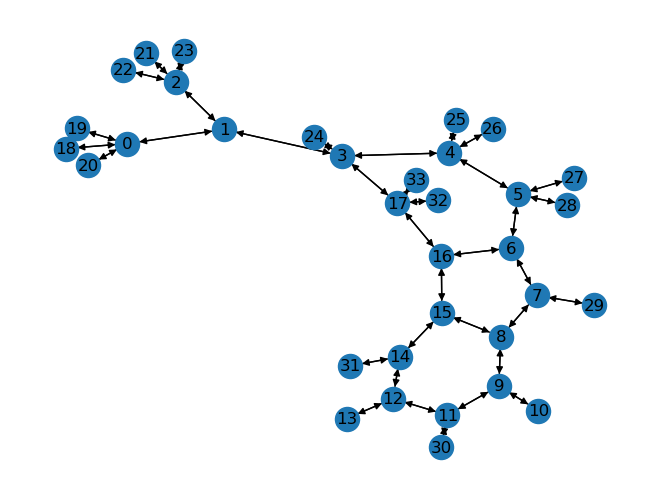

In [22]:
import networkx as nx
from torch_geometric.utils import to_networkx
for databatch in trainloader:
    data = databatch[1]
    print(data)
    g = to_networkx(data)
    nx.draw(g, with_labels=True)
    print(data.x[:, 0])
    # 0: H, 5: C
    print(data.smiles)
    # print(g.nodes[0]["labels"])
    break